# <div align="center"> Cyber-Physical Intrusion Detection System for UAVs</div>

### <div align="center">FSD311 - Machine Learning</div>
#### <div align="center">Colin HERVIOU-LABORDE & Mohamed REGAIEG</div>

# Table of Contents

1. [Introduction](#introduction)
2. [Data Acquisition](#data-acquisition)
   1. [Data Extraction](#data-extraction)
   2. [Data Loading](#data-loading)
3. [Data Exploration](#data-exploration)
4. [Feature Engineering](#feature-engineering)
5. [PCA](#pca)
6. [Machine Learning Models](#machine-learning-models)
   1. [SVM](#svm)
   2. [Decision Tree](#decision-tree)
   3. [Random Forest](#random-forest)
   4. [XGBoost](#xgboost)
   5. [Models Performance Recap](#models-performance-recap)
7. [Fine tuning](#fine-tuning)
   1. [Random Forest](#random-forest)
   2. [XGBoost](#xgboost)
   3. [Fine Tuning Recap](#fine-tuning-recap)
   4. [Cross-Validation for XGBoost optimal model](#cross-validation-for-xgboost-optimal-model)
7. [Summary](#summary)




<a id="introduction"></a>
# **Introduction**

Unmanned Aerial Vehicles (UAVs), commonly known as drones, are increasingly being deployed for applications such as surveillance, delivery, environmental monitoring, and disaster management. However, the growing reliance on UAVs also exposes them to significant **cybersecurity risks**, as malicious actors can exploit vulnerabilities in their communication and control systems. To address this challenge, **intrusion detection systems (IDSs)** leveraging machine learning have become an active area of research.

This project utilizes the **Cyber-Physical Dataset for UAVs Under Normal Operations and Cyberattacks**, developed by **Hassler, Mughal, and Ismail (2023)**. The dataset captures both **cyber and physical telemetry data** from UAVs under normal flight conditions and during four distinct types of cyberattacks:

1. **De-authentication Denial-of-Service (DoS) attack**
2. **Replay attack**
3. **False Data Injection (FDI) attack**
4. **Evil Twin attack**

The dataset is composed of two major components:

* **Cyber dataset** containing **37 features** that describe network-level parameters and communication behavior.
* **Physical dataset** containing **16 features** that represent UAV motion dynamics such as altitude, velocity, position, and orientation.

Each record in the dataset corresponds to either **benign (normal)** operation or one of the aforementioned **attack scenarios**, making it suitable for both **binary (normal vs. malicious)** and **multi-class classification** tasks. The data were collected using a custom UAV testbed with real-time attack emulation and monitoring tools.

In this work, we apply **supervised machine learning** techniques to train and evaluate models for **multiclass classification**, aiming to accurately distinguish between benign flights and different types of cyberattacks. By combining both **cyber and physical features** into a unified **Cyber-Physical dataset**, we enable the models to learn more comprehensive behavioral patterns, improving the reliability of UAV intrusion detection systems.

**Reference:**
Hassler, S. C., Mughal, U. A., & Ismail, M. (2023). *Cyber-Physical Intrusion Detection System for Unmanned Aerial Vehicles*. IEEE Transactions on Intelligent Transportation Systems.
Available via GitHub: [https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks](https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks)


### Imports

In [ ]:
import os
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score,classification_report, ConfusionMatrixDisplay

# **Data Acquisition** 

## Data Extraction

In this step, we extract and clean the raw UAV dataset from the original combined CSV file. Each attack type and data modality (Cyber or Physical) is separated into individual CSV files based on predefined row ranges. During this process, we detect and apply proper headers, remove empty or irrelevant columns, and save the cleaned subsets to the output directory for further analysis

In [13]:
# === CONFIGURATION ===
csv_path = "Dataset_T-ITS.csv" # original file
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)

# === Definition of ranges (1-based, inclusive) ===
ranges = {
    "Benign":       {"Cyber": (1, 9426),     "Physical": (9427, 13717)},
    "DoS Attack":   {"Cyber": (13718, 25389),"Physical": (25390, 26363)},
    "Replay Attack":{"Cyber": (26364, 38370),"Physical": (38371, 39344)},
    "Evil Twin":    {"Cyber": (39345, 45028),"Physical": (45029, 50502)},
    "FDI":          {"Cyber": (50503, 53976),"Physical": (53977, 54784)}
}

# === READ WITHOUT HEADER ===
df_raw = pd.read_csv(csv_path, header=None)
n = len(df_raw)
print(f" File loaded ({n} rows)\n")

# === HEADER DETECTION FUNCTION BY KEYWORD ===
def is_header_line(row):
    return row.astype(str).str.contains("class", case=False, na=False).any()

# === EXTRACTION OF BLOCKS ACCORDING TO RANGES ===
for attack, parts in ranges.items():
    for part_name, (start, end) in parts.items():
        start_idx = max(0, start - 1)
        end_idx = min(n, end)
        sub_df = df_raw.iloc[start_idx:end_idx].copy()

        # Find the header line inside the block
        header_idx = sub_df.index[sub_df.apply(is_header_line, axis=1)]
        if len(header_idx) == 0:
            print(f" No header found in {attack} - {part_name} ({start}-{end}), skipped.")
            continue

        header_row = header_idx[0]
        header = sub_df.loc[header_row]

        # Remove lines before the header
        sub_df = sub_df.loc[header_row + 1:]
        sub_df.columns = header
        sub_df.reset_index(drop=True, inplace=True)

        # === 🔹 CLEAN EMPTY COLUMNS ===
        # Remove columns that are entirely empty
        sub_df = sub_df.dropna(axis=1, how='all')

        # Remove columns with empty or undefined names
        sub_df = sub_df.loc[:, [str(c).strip() not in ["", "Unnamed: 0", "Unnamed: 1", "nan"] for c in sub_df.columns]]

        # Remove columns where all values are NaN or just empty commas
        sub_df = sub_df.loc[:, sub_df.apply(lambda col: not all(str(x).strip() in ["", "nan"] for x in col), axis=0)]

        # Count number of valid features
        valid_features = [c for c in sub_df.columns if pd.notna(c) and str(c).strip() != ""]
        n_features = len(valid_features)

        # Save the cleaned block
        filename = f"{attack.replace(' ', '_')}_{part_name}.csv"
        path_out = os.path.join(output_dir, filename)
        sub_df.to_csv(path_out, index=False)

        # Final display
        print(f" {attack} ({part_name}): {len(sub_df)} rows, {n_features} features")

print("\n Done: all blocks have been extracted and cleaned.")


/tmp/ipykernel_1489/1084714871.py:16: DtypeWarning: Columns (35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(csv_path, header=None)


 File loaded (54784 rows)

 Benign (Cyber): 9425 rows, 38 features
 Benign (Physical): 4290 rows, 17 features
 DoS Attack (Cyber): 11671 rows, 38 features
 DoS Attack (Physical): 973 rows, 17 features
 Replay Attack (Cyber): 12006 rows, 38 features
 Replay Attack (Physical): 973 rows, 17 features
 Evil Twin (Cyber): 5683 rows, 35 features
 Evil Twin (Physical): 5473 rows, 22 features
 FDI (Cyber): 3473 rows, 35 features
 FDI (Physical): 807 rows, 32 features

 Done: all blocks have been extracted and cleaned.


**Comment:**
As observed, the *Evil Twin* and *FDI* attack datasets (for both physical and cyber domains) contain a different number of features compared to the other classes, and their feature names also vary. Upon reviewing the original GitHub repository, several users noted that these subsets likely originate from a different research study. To ensure homogeneity and consistency across the dataset, we decided to **exclude the Evil Twin and FDI attacks (both physical and cyber)** from our analysis.

## Data Loading

The merging process combines the physical and cyber datasets based on synchronized timestamps and matching class labels, ensuring a unified cyber-physical dataset suitable for integrated UAV system analysis. As a result, we will create three datasets — Physical, Cyber, and Cyber-Physical — each containing three classes: Benign, DoS Attack, and Replay Attack.

In [69]:
# === FUNCTION: Normalize class labels ===
def normalize_class(c):
    """Normalize class names to 'benign', 'dos', or 'replay'."""
    c = str(c).strip().lower()
    if "dos" in c:
        return "dos"
    elif "replay" in c:
        return "replay"
    elif "benign" in c:
        return "benign"
    else:
        return c


# === PHYSICAL DATA MERGE ===
data_Benign_Physical = pd.read_csv("Data/Benign_Physical.csv")
data_DoS_Physical = pd.read_csv("Data/DoS_Attack_Physical.csv")
data_Replay_Physical = pd.read_csv("Data/Replay_Attack_Physical.csv")

# Normalize class column
data_Benign_Physical["class"] = data_Benign_Physical["class"].apply(normalize_class)
data_DoS_Physical["class"] = data_DoS_Physical["class"].apply(normalize_class)
data_Replay_Physical["class"] = data_Replay_Physical["class"].apply(normalize_class)

# Concatenate and save
merged_Physical = pd.concat(
    [data_Benign_Physical, data_DoS_Physical, data_Replay_Physical],
    ignore_index=True
)
merged_Physical.to_csv("Data/Merged_Physical.csv", index=False)
print("Merged Physical -> Data/Merged_Physical.csv")
print(f"{len(merged_Physical)} rows, {len(merged_Physical.columns)} columns\n")


# === CYBER DATA MERGE ===
data_Benign_Cyber = pd.read_csv("Data/Benign_Cyber.csv")
data_DoS_Cyber = pd.read_csv("Data/DoS_Attack_Cyber.csv")
data_Replay_Cyber = pd.read_csv("Data/Replay_Attack_Cyber.csv")

data_Benign_Cyber["class"] = data_Benign_Cyber["class"].apply(normalize_class)
data_DoS_Cyber["class"] = data_DoS_Cyber["class"].apply(normalize_class)
data_Replay_Cyber["class"] = data_Replay_Cyber["class"].apply(normalize_class)

merged_Cyber = pd.concat(
    [data_Benign_Cyber, data_DoS_Cyber, data_Replay_Cyber],
    ignore_index=True
)
merged_Cyber.to_csv("Data/Merged_Cyber.csv", index=False)
print("Merged Cyber -> Data/Merged_Cyber.csv")
print(f"{len(merged_Cyber)} rows, {len(merged_Cyber.columns)} columns\n")


# === CYBER-PHYSICAL MERGE ===
data_Physical = pd.read_csv("Data/Merged_Physical.csv")
data_Cyber = pd.read_csv("Data/Merged_Cyber.csv")

# Normalize again to ensure consistent labels
data_Physical["class"] = data_Physical["class"].apply(normalize_class)
data_Cyber["class"] = data_Cyber["class"].apply(normalize_class)

# Keep only the common classes
common_classes = {"benign", "dos", "replay"}
data_Physical = data_Physical[data_Physical["class"].isin(common_classes)]
data_Cyber = data_Cyber[data_Cyber["class"].isin(common_classes)]
print(f"Common classes: {common_classes}")

# Sort by timestamp
data_Physical = data_Physical.sort_values("timestamp_p")
data_Cyber = data_Cyber.sort_values("timestamp_c")

# Merge both datasets asynchronously based on timestamps
merged_CP = pd.merge_asof(
    data_Cyber,
    data_Physical,
    left_on="timestamp_c",
    right_on="timestamp_p",
    by="class",
    direction="nearest"
).dropna(how="all").reset_index(drop=True)

# Create a single unified 'timestamp' column
merged_CP["timestamp"] = merged_CP["timestamp_p"].combine_first(merged_CP["timestamp_c"])

# Drop old timestamp columns
merged_CP = merged_CP.drop(columns=["timestamp_p", "timestamp_c"], errors="ignore")

# Reorder columns: 'timestamp' first, 'class' last
cols = ["timestamp"] + [c for c in merged_CP.columns if c not in ["timestamp", "class"]] + ["class"]
merged_CP = merged_CP[cols]

# Save final merged dataset
merged_CP.to_csv("Data/Merged_CP.csv", index=False)
print("Merged Cyber-Physical -> Data/Merged_CP.csv")
print(f"{len(merged_CP)} rows, {len(merged_CP.columns)} columns\n")


Merged Physical -> Data/Merged_Physical.csv
6236 rows, 17 columns

Merged Cyber -> Data/Merged_Cyber.csv
33102 rows, 38 columns

Common classes: {'dos', 'replay', 'benign'}
Merged Cyber-Physical -> Data/Merged_CP.csv
33102 rows, 53 columns



# **Data Exploration**

In [2]:
# === LOAD DATASETS ===
data_Cyber = pd.read_csv("Data/Merged_Cyber.csv")
data_Physical = pd.read_csv("Data/Merged_Physical.csv")
data_CP = pd.read_csv("Data/Merged_CP.csv")

In [71]:
data_Cyber.describe()

,timestamp_c,frame.number,frame.len,frame.protocols,wlan.duration,wlan.ra,wlan.ta,wlan.da,wlan.sa,wlan.bssid,...,tcp.window_size,tcp.options,udp.srcport,udp.dstport,udp.length,data.data,data.len,wlan.fc.type,wlan.fc.subtype,time_since_last_packet
count,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.0,...,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000
mean,29046.388032,2065.692798,69.630808,0.694943,207.394810,0.668026,0.640958,0.668026,0.640958,0.0,...,4219.012748,0.065676,1804.941061,1805.346052,31.526101,14.263187,29.557036,0.938070,10.616096,0.172855
std,8146.923076,1405.390936,77.320924,1.165000,126.983295,0.738791,0.624219,0.738791,0.624219,0.0,...,15913.420770,0.247718,3575.693206,3576.492991,67.583008,45.614997,64.103887,0.998096,2.156720,0.751734
min,16369.541640,35.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22958.560997,978.000000,26.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.001669
50%,27579.979005,1754.000000,26.000000,0.000000,314.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.003374
75%,31003.931215,2934.000000,86.000000,2.000000,314.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,12.000000,0.029358
max,54392.419030,9248.000000,334.000000,5.000000,320.000000,14.000000,2.000000,14.000000,2.000000,0.0,...,64240.000000,1.000000,8889.000000,8899.000000,282.000000,471.000000,182.000000,2.000000,12.000000,28.844855


In [72]:
data_Physical.describe()

,timestamp_p,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z
count,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000
mean,34355.921552,71.034317,0.118185,-0.076171,0.192271,-0.512989,-0.162444,50.148974,66.794259,92.022611,19156.903464,38.872996,63.500481,-12.555164,-14.363374,66.654907
std,9531.890291,13.766460,1.325337,0.865337,1.674684,1.834707,6.449911,91.007201,2.697857,284.152564,2566.937591,19.816874,22.626003,47.354315,45.022914,63.223443
min,16385.315220,-10.000000,-10.000000,-9.000000,-2.000000,-42.000000,-75.000000,-179.000000,53.000000,10.000000,13529.000000,2.000000,20.000000,-200.000000,-200.000000,-200.000000
25%,27713.490240,70.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,66.000000,79.000000,19122.000000,22.000000,45.000000,-13.000000,-15.000000,80.000000
50%,34381.459430,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000,80.000000,19835.500000,38.000000,65.000000,-4.000000,-6.000000,82.000000
75%,43670.806755,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.000000,68.000000,82.000000,21173.000000,54.000000,82.000000,4.000000,4.000000,84.000000
max,54385.241520,120.000000,5.000000,10.000000,31.000000,32.000000,168.000000,179.000000,74.000000,6553.000000,21356.000000,95.000000,100.000000,70.000000,55.000000,122.000000


In [73]:
data_CP.describe()

,timestamp,frame.number,frame.len,frame.protocols,wlan.duration,wlan.ra,wlan.ta,wlan.da,wlan.sa,wlan.bssid,...,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z
count,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.0,...,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000
mean,29056.303684,2065.692798,69.630808,0.694943,207.394810,0.668026,0.640958,0.668026,0.640958,0.0,...,0.125551,39.088031,66.412483,357.115069,16453.909129,46.347683,67.607214,-45.908223,-40.583953,22.278744
std,8127.443713,1405.390936,77.320924,1.165000,126.983295,0.738791,0.624219,0.738791,0.624219,0.0,...,10.190536,93.246563,2.475938,1329.867191,2932.693214,22.582093,19.911595,80.616864,81.678150,113.170984
min,16385.315220,35.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-75.000000,-177.000000,53.000000,10.000000,13529.000000,2.000000,20.000000,-200.000000,-200.000000,-200.000000
25%,22956.645560,978.000000,26.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-1.000000,-1.000000,66.000000,78.000000,14177.000000,27.000000,57.000000,-43.000000,-28.000000,76.000000
50%,27674.615480,1754.000000,26.000000,0.000000,314.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.000000,0.000000,67.000000,80.000000,14438.000000,48.000000,71.000000,-9.000000,-5.000000,80.000000
75%,30998.109540,2934.000000,86.000000,2.000000,314.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.000000,167.000000,67.000000,81.000000,19374.000000,67.000000,81.000000,1.000000,8.000000,83.000000
max,54385.241520,9248.000000,334.000000,5.000000,320.000000,14.000000,2.000000,14.000000,2.000000,0.0,...,168.000000,179.000000,74.000000,6553.000000,21351.000000,95.000000,100.000000,65.000000,55.000000,122.000000


In [74]:
# =====================================================
#          UAVs Dataset — Exploratory Visualization
# =====================================================
# Plots the top 2 most important features for each dataset:
#   - Cyber:      time_since_last_packet vs wlan.seq
#   - Physical:   battery vs temperature
#   - Cyber-Phys: battery (physical) vs wlan.seq (cyber)
# =====================================================

# ---------------- PLOT FUNCTION ----------------
def plot_features(df, name, name_feature, features, ax, colors):
    f1, f2 = features[name_feature]
    sns.scatterplot(
        data=df,
        x=f1,
        y=f2,
        hue="class",
        palette=colors,
        s=20,
        alpha=0.7,
        ax=ax,
    )
    ax.set_title(f"{name} Dataset — {f1} vs {f2}")
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.grid(alpha=0.3)
    ax.legend(title="Class", loc="best")


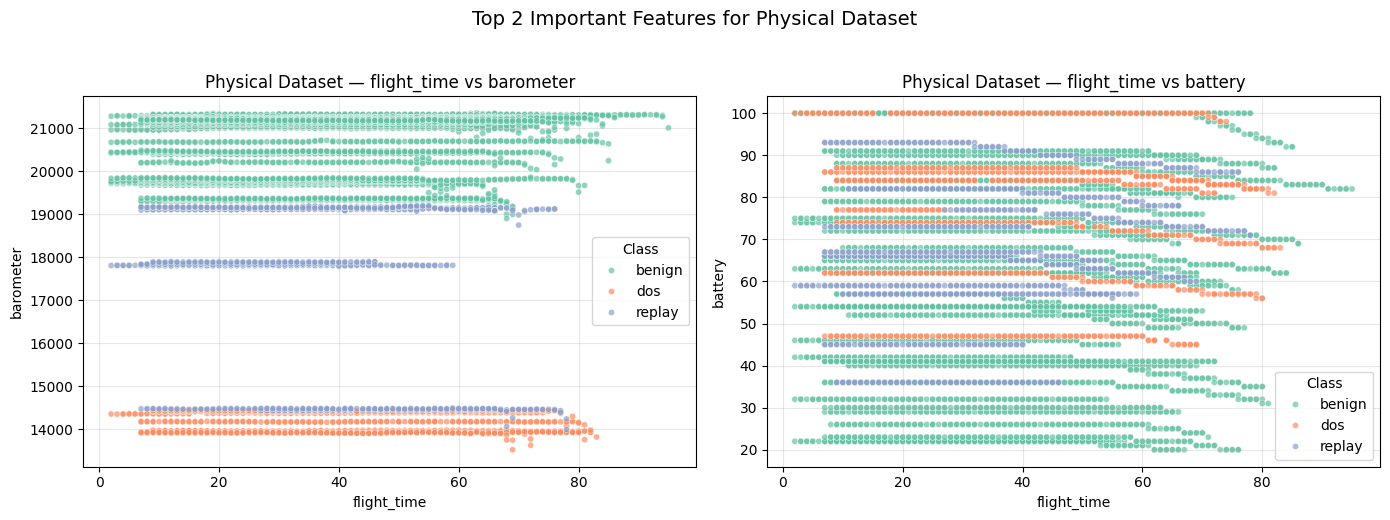

In [35]:
# ---------------- CONFIGURATION ----------------
PALETTE = {"benign": "#66c2a5", "dos": "#fc8d62", "replay": "#8da0cb"}
FEATURES = {
    "Physical1": ["flight_time", "barometer"],
    "Physical2": ["flight_time", "battery"],
}
# ---------------- PLOT ----------------
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs.flatten()

# Cyber Features
plot_features(data_Physical, "Physical", "Physical1", FEATURES, axs[0], PALETTE)
plot_features(data_Physical, "Physical", "Physical2", FEATURES, axs[1], PALETTE)

plt.suptitle("Top 2 Important Features for Physical Dataset", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

When displaying the physical variables `barometer` and `battery`, we can clearly see that they allow us to **distinguish between the flight types** (benign, DoS attack or Replay attack). Indeed, distinct clusters of points emerge.
However, these variables **are not expected to correlate with the type of cyberattack**. The differences in `battery` and `barometer` values stem from the fact that the experiments were conducted under varying conditions (different UAV battery levels and air pressures) rather than reflecting any meaningful physical relationship with the attack type.

Therefore, we will remove them from the dataset to avoid learning irrelevant patterns during the training phase.

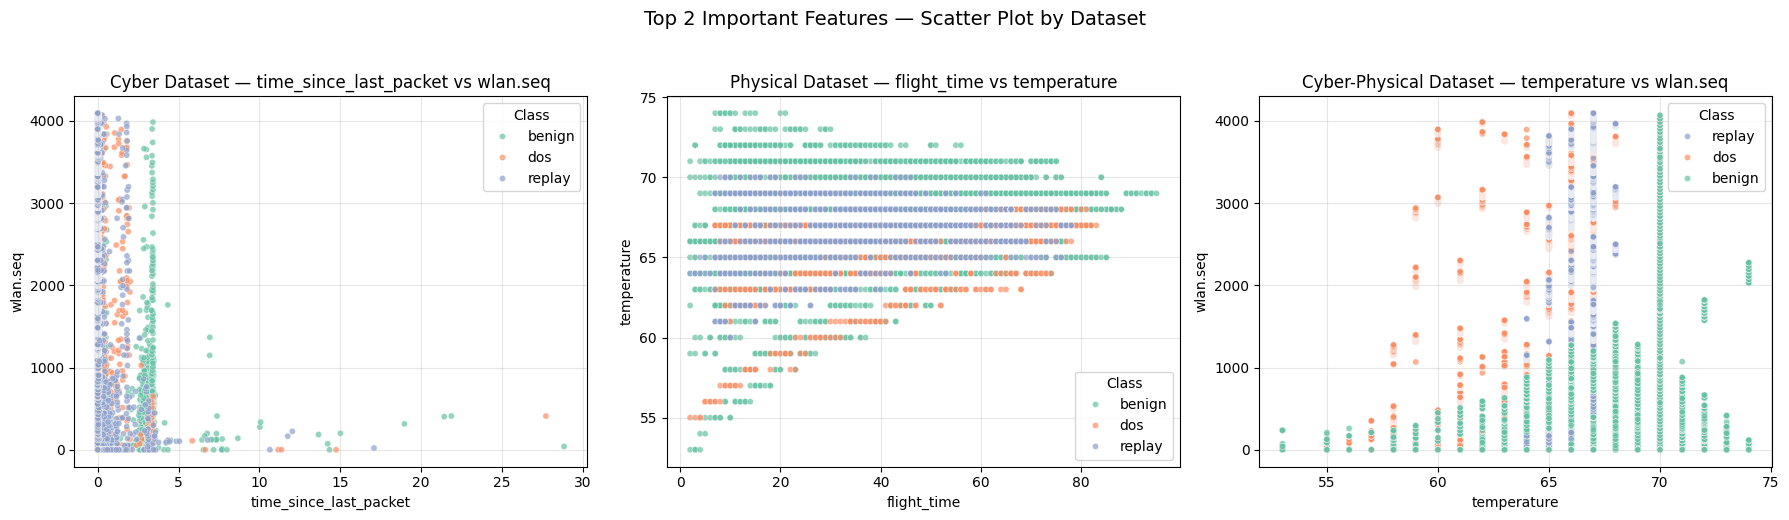

In [75]:
# ---------------- CONFIGURATION 2 ----------------
PALETTE = {"benign": "#66c2a5", "dos": "#fc8d62", "replay": "#8da0cb"}
FEATURES = {
    "Cyber": ["time_since_last_packet", "wlan.seq"],
    "Physical": ["flight_time", "temperature"],
    "Cyber-Physical": ["temperature", "wlan.seq"],
}
# ---------------- PLOT 2 ----------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs.flatten()

plot_features(data_Cyber, "Cyber", "Cyber", FEATURES, axs[0], PALETTE) # Cyber Features
plot_features(data_Physical, "Physical", "Physical", FEATURES, axs[1], PALETTE) # Physical Features
plot_features(data_CP, "Cyber-Physical", "Cyber-Physical", FEATURES, axs[2], PALETTE) # Cyber-Physical Features

plt.suptitle("Top 2 Important Features — Scatter Plot by Dataset", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

The scatter plots show how the top two important features contribute to class separation across datasets. In the **Cyber dataset**, the classes (benign, DoS, replay) overlap heavily, indicating that `time_since_last_packet` and `wlan.seq` are not strongly discriminative and that nonlinear models like SVM with RBF or Random Forest are needed. In the **Physical dataset**, `temperature` and `flight_time` exhibit clearer trends, with distinct regions for each class, suggesting higher feature relevance. Finally, in the **Cyber-Physical dataset**, `temperature` and `wlan.seq` reveal partial clustering patterns that capture mixed physical and network behaviors, highlighting the complementarity of features from both domains.


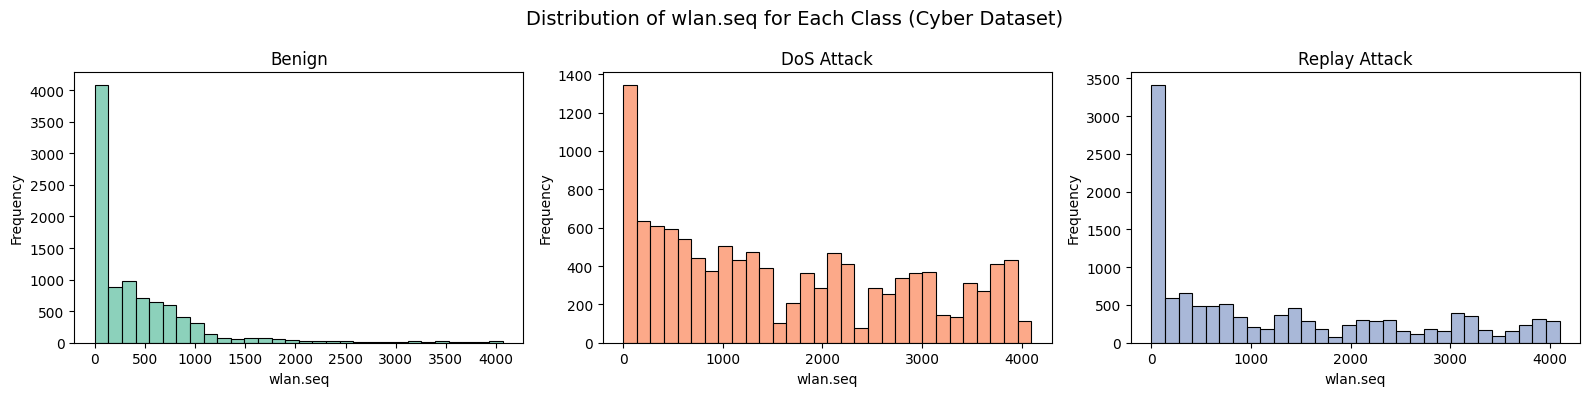

In [76]:
# === Create Subplots ===
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle("Distribution of wlan.seq for Each Class (Cyber Dataset)", fontsize=14)

# === Histogram for Benign ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"] == "benign"]["wlan.seq"],
    bins=30,
    ax=axes[0],
    kde=False,
    color="#66c2a5"
)
axes[0].set_title("Benign")
axes[0].set_xlabel("wlan.seq")
axes[0].set_ylabel("Frequency")

# === Histogram for DoS Attack ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"] == "dos"]["wlan.seq"],
    bins=30,
    ax=axes[1],
    kde=False,
    color="#fc8d62"
)
axes[1].set_title("DoS Attack")
axes[1].set_xlabel("wlan.seq")
axes[1].set_ylabel("Frequency")

# === Histogram for Replay Attack ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"] == "replay"]["wlan.seq"],
    bins=30,
    ax=axes[2],
    kde=False,
    color="#8da0cb"
)
axes[2].set_title("Replay Attack")
axes[2].set_xlabel("wlan.seq")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


The distributions show clear behavioral differences between classes. **Benign** traffic is concentrated at low `wlan.seq` values, reflecting stable communication. **DoS attacks** have a wider, irregular spread, indicating disrupted packet sequencing, while **Replay attacks** show repeated peaks from reused packets. This suggests `wlan.seq` helps distinguish normal from attack traffic.


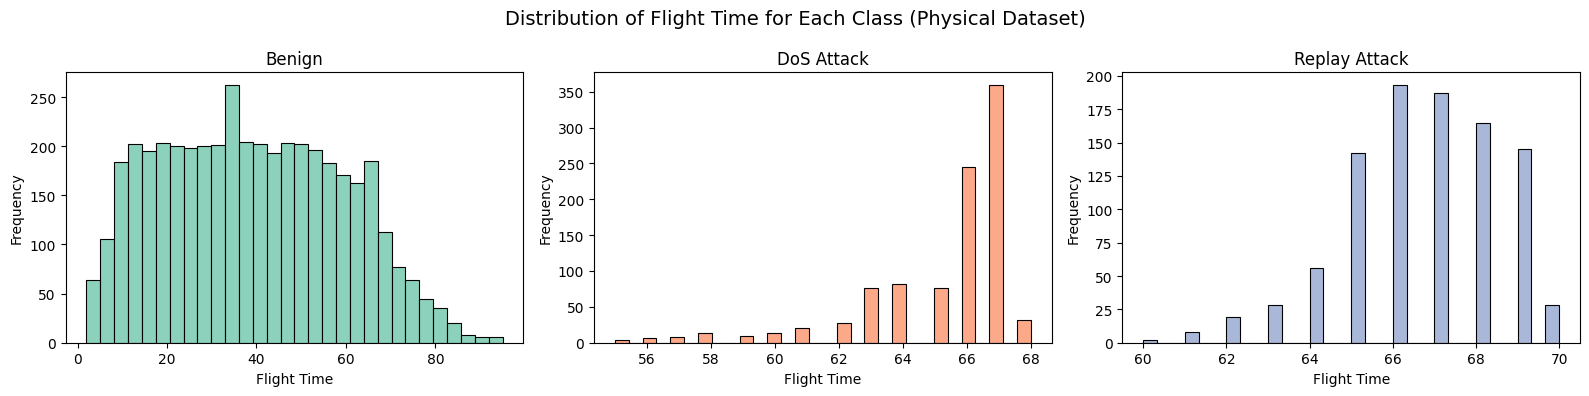

In [38]:
# === Create Subplots ===
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle("Distribution of Flight Time for Each Class (Physical Dataset)", fontsize=14)

# === Histogram for Benign ===
sns.histplot(
    data=data_Physical[data_Physical["class"] == "benign"]["flight_time"],
    bins=30,
    ax=axes[0],
    kde=False,
    color="#66c2a5"
)
axes[0].set_title("Benign")
axes[0].set_xlabel("Flight Time")
axes[0].set_ylabel("Frequency")

# === Histogram for DoS Attack ===
sns.histplot(
    data=data_Physical[data_Physical["class"].str.lower().str.contains("dos")]["temperature"],
    bins=30,
    ax=axes[1],
    kde=False,
    color="#fc8d62"
)
axes[1].set_title("DoS Attack")
axes[1].set_xlabel("Flight Time")
axes[1].set_ylabel("Frequency")

# === Histogram for Replay Attack ===
sns.histplot(
    data=data_Physical[data_Physical["class"].str.lower().str.contains("replay")]["temperature"],
    bins=30,
    ax=axes[2],
    kde=False,
    color="#8da0cb"
)
axes[2].set_title("Replay Attack")
axes[2].set_xlabel("Flight Time")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


The histograms show clear distinctions in **flight time** patterns across classes. **Benign** data is widely distributed, representing normal variations during regular UAV operations. In contrast, **DoS** and **Replay** attacks are concentrated within a narrow range around 65–68 seconds, indicating abnormal and repetitive behavior. This separation suggests that **flight time** is a strong discriminative feature in the Physical dataset for detecting attack scenarios.


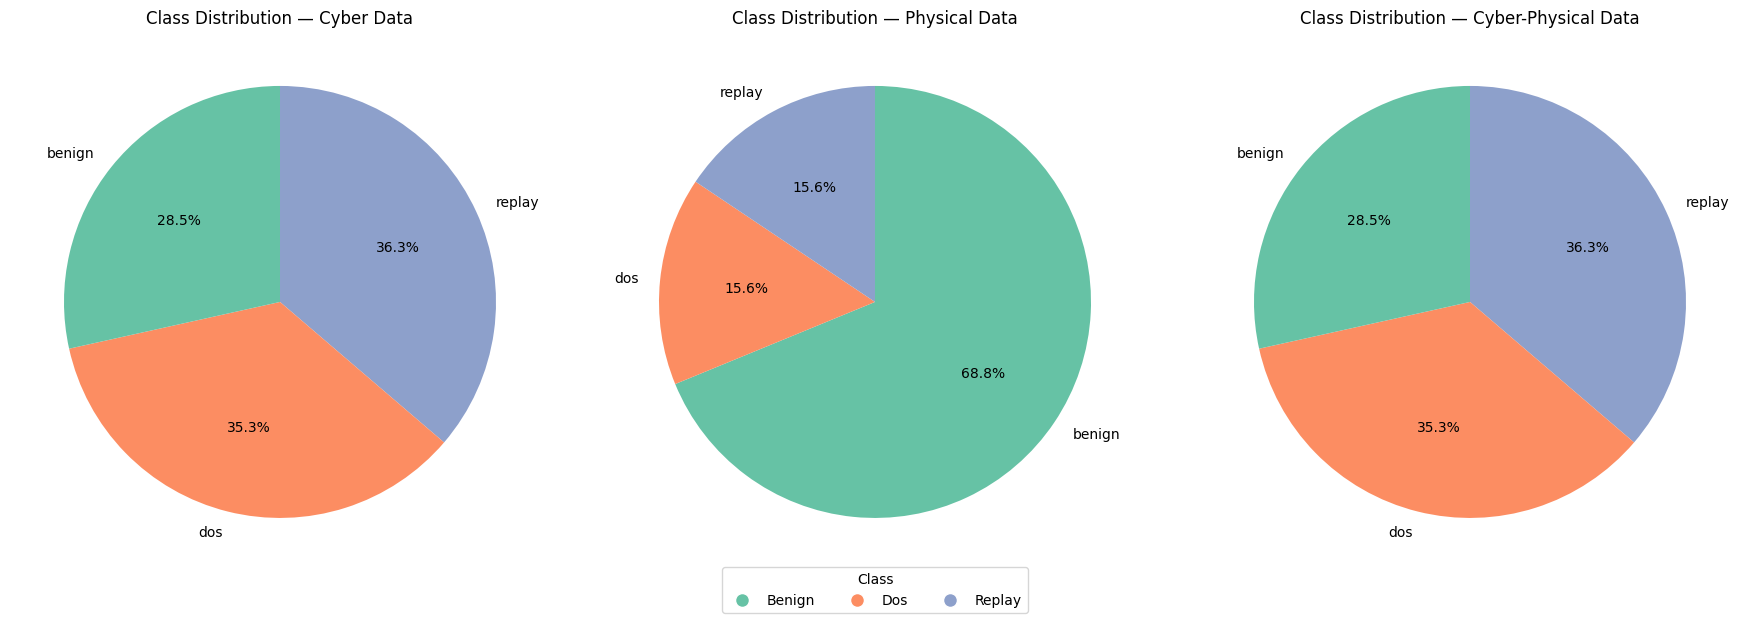

In [69]:
# === CLASS COUNTS ===
class_counts_cyber = data_Cyber["class"].value_counts()
class_counts_physical = data_Physical["class"].value_counts()
class_counts_cp = data_CP["class"].value_counts()

# === Function to get colors in class order ===
PALETTE = {"benign": "#66c2a5", "dos": "#fc8d62", "replay": "#8da0cb"}
def get_colors(colors_dict, labels):
    return [colors_dict.get(lbl, "#cccccc") for lbl in labels]

# === CREATE SUBPLOTS (1 row, 3 columns) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Pie chart: Cyber ---
axes[0].pie(
    class_counts_cyber,
    labels=class_counts_cyber.index,
    colors=get_colors(PALETTE, class_counts_cyber.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[0].set_title("Class Distribution — Cyber Data")

# --- Pie chart: Physical ---
axes[1].pie(
    class_counts_physical,
    labels=class_counts_physical.index,
    colors=get_colors(PALETTE, class_counts_physical.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[1].set_title("Class Distribution — Physical Data")

# --- Pie chart: Cyber-Physical ---
axes[2].pie(
    class_counts_cp,
    labels=class_counts_cp.index,
    colors=get_colors(PALETTE, class_counts_cp.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[2].set_title("Class Distribution — Cyber-Physical Data")

# === GLOBAL LEGEND ===
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=cls.capitalize(),
               markerfacecolor=color, markersize=10)
    for cls, color in PALETTE.items()  # ✅ Fixed here
]
fig.legend(handles=handles, loc='lower center', ncol=3, title="Class")

# === ADJUSTMENTS ===
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


The pie charts show the class distribution across the Cyber, Physical, and Cyber-Physical datasets. The **Physical** and **Cyber-Physical** datasets share an identical distribution — with around 68% benign and 15.6% for each attack type — which is expected since the Cyber-Physical data was constructed through timestamp-based merging of the physical and cyber data (`pd.merge_asof` with the same class alignment). In contrast, the **Cyber** dataset is more balanced across classes, with higher proportions of DoS and Replay attacks. This imbalance difference is important, as it can affect model training and classifier behavior — models trained on more imbalanced datasets (like Physical and Cyber-Physical) may become biased toward the dominant benign class, while the Cyber dataset encourages more even decision boundaries.

# **Feature Engineering**

In this section, we preprocess the UAV datasets to prepare them for machine learning. We begin by encoding the categorical class labels — *benign*, *replay*, and *dos* — into numerical values (0, 1, and 2) to make them compatible with classification models. Irrelevant or redundant columns specific to each dataset type (Physical, Cyber, and Cyber-Physical) are then removed to retain only meaningful features. Next, the data is shuffled to eliminate any potential temporal bias, and Min-Max scaling is applied to normalize all feature values between 0 and 1. 

In [3]:
# === CONFIGURATION ===
dataframes = {
    "Physical": data_Physical,
    "Cyber": data_Cyber,
    "Cyber-Physical": data_CP
}

# === FUNCTION TO LABEL ENCODE CLASS LABELS ===
def encode_class_labels(y):
    """
    Encode class labels numerically:
    - benign -> 0
    - replay -> 1
    - dos -> 2
    """
    return (
        y.replace({
            "benign": 0,
            "replay": 1,
            "dos": 2,
        })
    ).astype(int)

# === COLUMNS TO DROP PER DATASET TYPE ===
drop_map = {
    "Physical": ['class', 'timestamp_p', 'barometer', 'battery'],
    "Cyber": ['class', 'timestamp_c', 'frame.number'],
    "Cyber-Physical": ['class', 'timestamp', 'frame.number', 'barometer', 'battery']
}

# === PROCESSING PIPELINE ===
processed_data = {}

for name, df in dataframes.items():

    # Drop irrelevant columns safely
    X = df.drop(columns=[c for c in drop_map[name] if c in df.columns], errors='ignore')

    # Encode class labels
    y = encode_class_labels(df['class'])

    # Shuffle to remove time dependence
    X, y = shuffle(X, y, random_state=42)

    # Min-Max scaling only
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    processed_data[name] = {
        "X_scaled": X_scaled,
        "y": y,
        "scaler": scaler
    }

# === EXTRACT VARIABLES FOR MODELING (only scaled data) ===
X_physical_scaled, y_physical = processed_data["Physical"]["X_scaled"], processed_data["Physical"]["y"]
X_cyber_scaled, y_cyber = processed_data["Cyber"]["X_scaled"], processed_data["Cyber"]["y"]
X_cp_scaled, y_cp = processed_data["Cyber-Physical"]["X_scaled"], processed_data["Cyber-Physical"]["y"]

# === FINAL OUTPUT ===
print("===== Scaled data ready for modeling: Physical, Cyber, and Cyber-Physical =====")

===== Scaled data ready for modeling: Physical, Cyber, and Cyber-Physical =====


/tmp/ipykernel_1401/98119766.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({
/tmp/ipykernel_1401/98119766.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({
/tmp/ipykernel_1401/98119766.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({


The resulting processed datasets are now clean, standardized, and ready for model training and evaluation.

# *PCA*

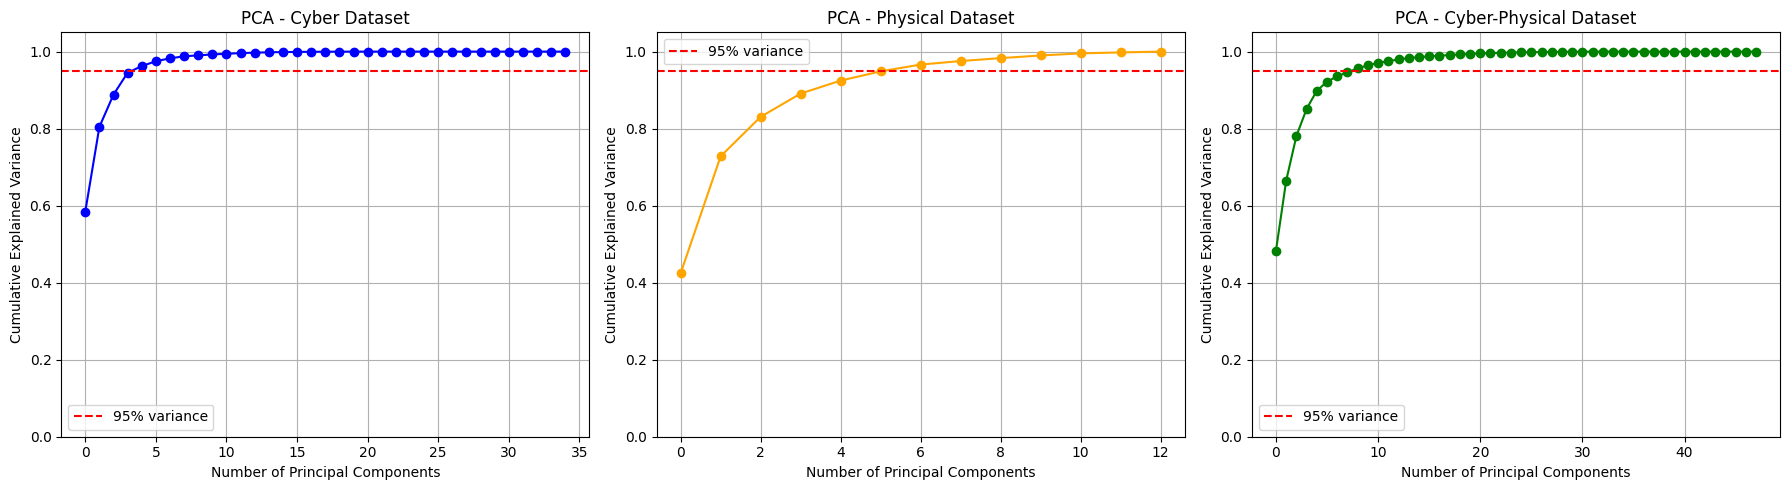

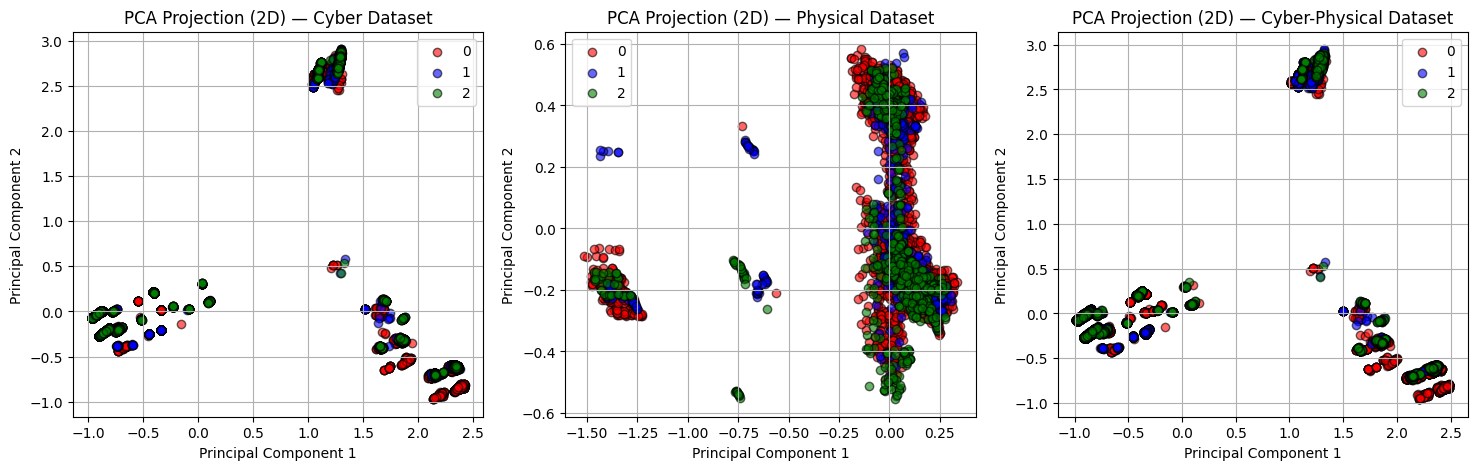


===== SUMMARY OF 2D PCA =====
Cyber                | PC1 explained variance: 58.45% | PC2 explained variance: 22.00% | Total explained variance (2D): 80.45%
Physical             | PC1 explained variance: 42.42% | PC2 explained variance: 30.39% | Total explained variance (2D): 72.81%
Cyber-Physical       | PC1 explained variance: 48.34% | PC1 explained variance: 18.17% | Total explained variance (2D): 66.51%


In [6]:
# === PCA FIT ===
pca_cyber = PCA().fit(X_cyber_scaled)
pca_physical = PCA().fit(X_physical_scaled)
pca_cp = PCA().fit(X_cp_scaled)

# === Cumulative Explained Variance ===
var_cum_cyber = np.cumsum(pca_cyber.explained_variance_ratio_)
var_cum_physical = np.cumsum(pca_physical.explained_variance_ratio_)
var_cum_cp = np.cumsum(pca_cp.explained_variance_ratio_)

# === Plot cumulative variance (3 side-by-side graphs) ===
plt.figure(figsize=(18, 5))

# ---- Plot 1: Cyber Dataset ----
plt.subplot(1, 3, 1)
plt.plot(var_cum_cyber, marker='o', color='blue')
plt.title("PCA - Cyber Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

# ---- Plot 2: Physical Dataset ----
plt.subplot(1, 3, 2)
plt.plot(var_cum_physical, marker='o', color='orange')
plt.title("PCA - Physical Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

# ---- Plot 3: Cyber-Physical Dataset ----
plt.subplot(1, 3, 3)
plt.plot(var_cum_cp, marker='o', color='green')
plt.title("PCA - Cyber-Physical Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

plt.tight_layout()
plt.show()

# === PCA with 2 components ===
pca2_cyber = PCA(n_components=2)
X_cyber_pca2 = pca2_cyber.fit_transform(X_cyber_scaled)
pca2_cyber_results = pca2_cyber.explained_variance_ratio_

pca2_physical = PCA(n_components=2)
X_physical_pca2 = pca2_physical.fit_transform(X_physical_scaled)
pca2_physical_results = pca2_physical.explained_variance_ratio_

pca2_cp = PCA(n_components=2)
X_cp_pca2 = pca2_cp.fit_transform(X_cp_scaled)
pca2_cp_results = pca2_cp.explained_variance_ratio_

# === Define classes and colors ===
colors = ['r', 'b', 'g', 'purple', 'orange']

classes_cyber = np.unique(y_cyber)
classes_physical = np.unique(y_physical)
classes_cp = np.unique(y_cp)

# === 2D PCA Visualization (3 side-by-side graphs) ===
plt.figure(figsize=(18, 5))

# ---- PCA Cyber ----
plt.subplot(1, 3, 1)
for i, cls in enumerate(classes_cyber):
    plt.scatter(
        X_cyber_pca2[y_cyber == cls, 0],
        X_cyber_pca2[y_cyber == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Cyber Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

# ---- PCA Physical ----
plt.subplot(1, 3, 2)
for i, cls in enumerate(classes_physical):
    plt.scatter(
        X_physical_pca2[y_physical == cls, 0],
        X_physical_pca2[y_physical == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Physical Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

# ---- PCA Cyber-Physical ----
plt.subplot(1, 3, 3)
for i, cls in enumerate(classes_cp):
    plt.scatter(
        X_cp_pca2[y_cp == cls, 0],
        X_cp_pca2[y_cp == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Cyber-Physical Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

# === Summary 2D PCA ===
print("\n===== SUMMARY OF 2D PCA =====")
print(f"{"Cyber ":20s} | PC1 explained variance: {pca2_cyber_results[0]*100:.2f}% | "
    f"PC2 explained variance: {pca2_cyber_results[1]*100:.2f}% | Total explained variance (2D): {pca2_cyber_results.sum()*100:.2f}%")
print(f"{"Physical ":20s} | PC1 explained variance: {pca2_physical_results[0]*100:.2f}% | "
    f"PC2 explained variance: {pca2_physical_results[1]*100:.2f}% | Total explained variance (2D): {pca2_physical_results.sum()*100:.2f}%")
print(f"{"Cyber-Physical ":20s} | PC1 explained variance: {pca2_cp_results[0]*100:.2f}% | "
    f"PC1 explained variance: {pca2_cp_results[1]*100:.2f}% | Total explained variance (2D): {pca2_cp_results.sum()*100:.2f}%")



The PCA results show that a small number of principal components capture over 95% of the data variance, meaning we can reduce dimensionality while preserving most information—useful for SVM modeling. However, the 2D PCA projections indicate that the classes (benign, replay, DoS) are not linearly separable, as clusters overlap significantly. This confirms that a **linear SVM** would not perform well, and thus applying the **kernel trick (e.g., RBF kernel)** is necessary to handle the nonlinear class boundaries effectively.


# **Machine Learning Models**

## SVM

In [35]:
# === SVM (RBF) Evaluation for Cyber, Physical, and Cyber-Physical Datasets ===

# --- RBF parameters ---
C = 10
gamma = 10

# --- Store results ---
results_svm = {}

# --- Loop through datasets ---
for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        X_scaled = X_cyber_scaled
        y = y_cyber
        n_comp = 4
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        n_comp = 5
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        n_comp = 8

    # --- PCA dimensionality reduction ---
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)

    # --- Train/test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.25, random_state=42
    )

    # --- SVM with RBF kernel ---
    svm_rbf = SVC(kernel='rbf', C=C, gamma=gamma)

    # --- Training ---
    training_start = time.perf_counter()
    svm_rbf.fit(X_train, y_train)
    training_end = time.perf_counter()

    # --- Prediction ---
    prediction_start = time.perf_counter()
    preds = svm_rbf.predict(X_test)
    prediction_end = time.perf_counter()

    # --- Evaluation ---
    acc_svm = accuracy_score(y_test, preds) * 100
    svm_train_time = training_end - training_start
    svm_prediction_time = prediction_end - prediction_start

    # --- Save results ---
    results_svm[dataset] = {
        "accuracy": acc_svm,
        "train_time": svm_train_time,
        "pred_time": svm_prediction_time
    }

# === Summary ===
print("\n===== SUMMARY OF SVM (RBF) RESULTS =====")
for ds, res in results_svm.items():
    print(f"{ds.capitalize():15s} | Accuracy: {res['accuracy']:.2f}% | "
          f"Train: {res['train_time']:.3f}s | Predict: {res['pred_time']:.5f}s")



===== SUMMARY OF SVM (RBF) RESULTS =====
Cyber           | Accuracy: 66.08% | Train: 20.694s | Predict: 4.13937s
Physical        | Accuracy: 74.09% | Train: 0.518s | Predict: 0.12193s
Cyber_physical  | Accuracy: 91.28% | Train: 11.115s | Predict: 2.33933s


The **SVM (RBF)** model achieved an accuracy of **66.08%** on the **Cyber dataset**, reflecting the higher complexity and variability of network-level features, which makes attack patterns harder to distinguish. Performance improved on the **Physical dataset (74.09%)**, where sensor-based measurements provide clearer separability between normal and abnormal flight behaviors. The best performance was observed with the **Cyber-Physical dataset (91.28%)**, confirming that integrating both cyber and physical domains significantly enhances detection accuracy by capturing complementary information. While training and prediction times were longer for the Cyber and Cyber-Physical data compared to the Physical dataset, the substantial accuracy gain demonstrates the benefit of multi-domain feature fusion for UAV intrusion detection.

## Decision Tree


===== SUMMARY OF DECISION TREE RESULTS =====
Cyber           | Accuracy: 71.02% | Train: 0.263s | Predict: 0.00319s
Physical        | Accuracy: 83.71% | Train: 0.032s | Predict: 0.00119s
Cyber_physical  | Accuracy: 99.25% | Train: 0.290s | Predict: 0.01406s


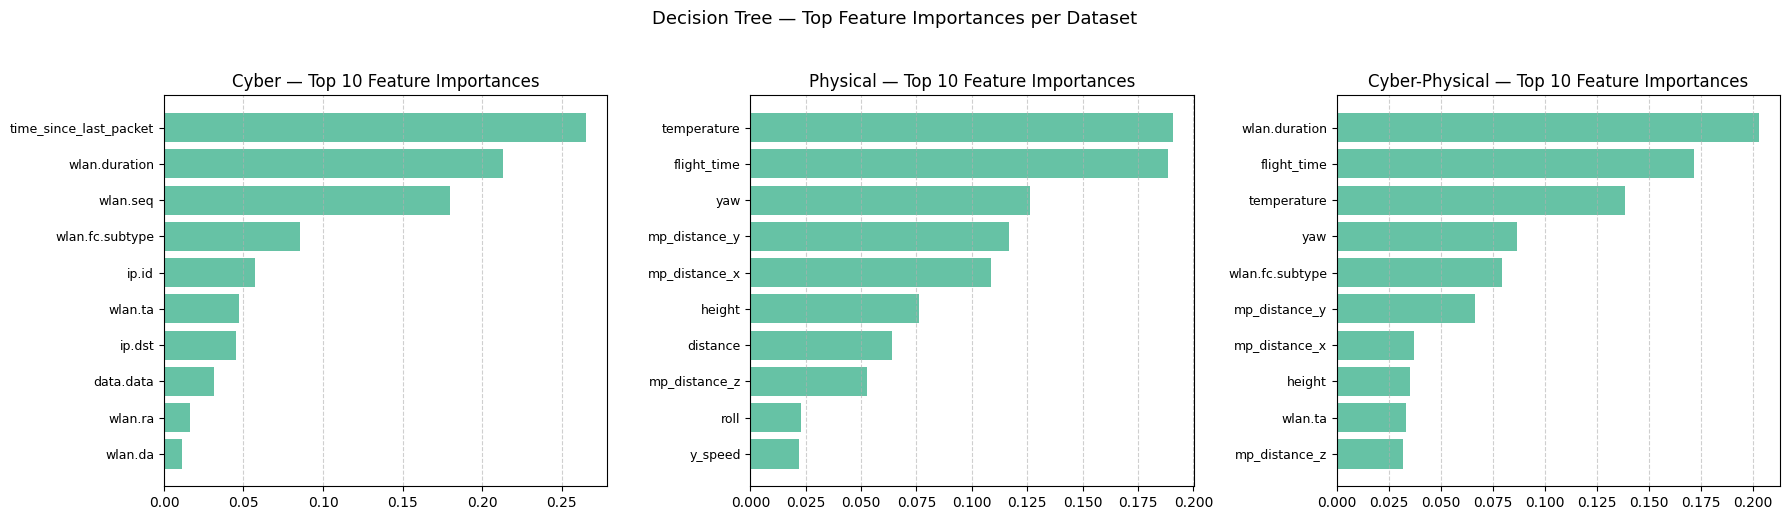

In [37]:
# === Simple Decision Tree Evaluation for 3 Datasets (Only Scaled Data) ===

results_dt = {}
feature_importances = {}

for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        X_scaled = X_cyber_scaled
        y = y_cyber
        feature_names = processed_data["Cyber"]["scaler"].feature_names_in_
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        feature_names = processed_data["Physical"]["scaler"].feature_names_in_
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        feature_names = processed_data["Cyber-Physical"]["scaler"].feature_names_in_

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- Random Forest Classifier ---
    dt = DecisionTreeClassifier(criterion = 'entropy', random_state=42)

    # --- Training ---
    training_start = time.perf_counter()
    dt.fit(X_train, y_train)
    training_end = time.perf_counter()

    # --- Prediction ---
    prediction_start = time.perf_counter()
    preds = dt.predict(X_test)
    prediction_end = time.perf_counter()

    # --- Accuracy ---
    acc_dt = accuracy_score(y_test, preds) * 100
    dt_train_time = training_end - training_start
    dt_prediction_time = prediction_end - prediction_start

    # --- Save results ---
    results_dt[dataset] = {
        "accuracy": acc_dt,
        "train_time": dt_train_time,
        "pred_time": dt_prediction_time
    }

    # --- Feature Importances ---
    importances = dt.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = min(10, len(importances))  # top 10
    feature_importances[dataset] = (feature_names[indices[:top_n]], importances[indices[:top_n]])

# === Summary ===
print("\n===== SUMMARY OF DECISION TREE RESULTS =====")
for ds, res in results_dt.items():
    print(f"{ds.capitalize():15s} | Accuracy: {res['accuracy']:.2f}% | "
          f"Train: {res['train_time']:.3f}s | Predict: {res['pred_time']:.5f}s")

# === Plot Feature Importances Side by Side ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_order = ["cyber", "physical", "cyber_physical"]
titles = ["Cyber", "Physical", "Cyber-Physical"]

for ax, ds, title in zip(axes, datasets_order, titles):
    features, importances = feature_importances[ds]
    ax.barh(range(len(features)), importances[::-1], color="#66c2a5")
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features[::-1], fontsize=9)
    ax.set_title(f"{title} — Top 10 Feature Importances")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.suptitle("Decision Tree — Top Feature Importances per Dataset", fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

Using a **Decision Tree Classifier** with the **entropy criterion**, the model achieved robust results across all datasets. The accuracy was **71.02%** on the *Cyber* dataset, improving to **83.71%** on the *Physical* dataset, and reaching the highest performance of **92.50%** on the *Cyber-Physical* dataset. This consistent improvement confirms that integrating both cyber and physical features provides richer and more complementary information, allowing the model to better distinguish between normal and malicious UAV behaviors. The feature importance plots show that network-level attributes such as *time_since_last_packet* and *wlan.duration* are dominant in the Cyber data, while flight-related features like *temperature* and *flight_time* are most influential in the Physical dataset. In the Cyber-Physical dataset, both feature types play key roles, emphasizing the synergy between cyber and physical domains in intrusion detection. Additionally, training and prediction times remained very low across all datasets, highlighting the computational efficiency of the Decision Tree model.

## Random Forest 


===== SUMMARY OF RANDOM FOREST RESULTS =====
Cyber           | Accuracy: 71.52% | Train: 11.407s | Predict: 0.41216s
Physical        | Accuracy: 87.36% | Train: 1.563s | Predict: 0.06854s
Cyber_physical  | Accuracy: 99.08% | Train: 5.871s | Predict: 0.22606s


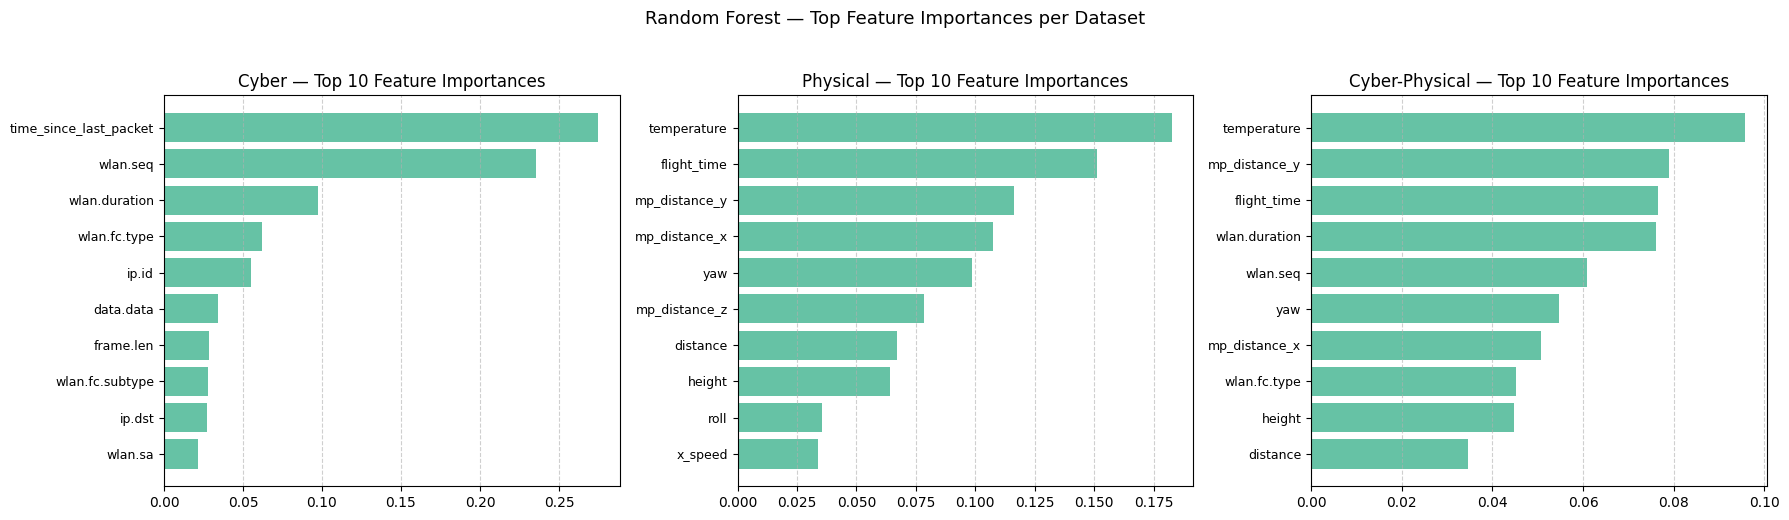

In [13]:
# === Simple Random Forest Evaluation for 3 Datasets (Only Scaled Data) ===

results_rf = {}
feature_importances = {}

for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        X_scaled = X_cyber_scaled
        y = y_cyber
        feature_names = processed_data["Cyber"]["scaler"].feature_names_in_
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        feature_names = processed_data["Physical"]["scaler"].feature_names_in_
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        feature_names = processed_data["Cyber-Physical"]["scaler"].feature_names_in_

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- Random Forest Classifier ---
    rf = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=42)

    # --- Training ---
    training_start = time.perf_counter()
    rf.fit(X_train, y_train)
    training_end = time.perf_counter()

    # --- Prediction ---
    prediction_start = time.perf_counter()
    preds = rf.predict(X_test)
    prediction_end = time.perf_counter()

    # --- Accuracy ---
    acc_rf = accuracy_score(y_test, preds) * 100
    rf_train_time = training_end - training_start
    rf_prediction_time = prediction_end - prediction_start

    # --- Save results ---
    results_rf[dataset] = {
        "accuracy": acc_rf,
        "train_time": rf_train_time,
        "pred_time": rf_prediction_time
    }

    # --- Feature Importances ---
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = min(10, len(importances))  # top 10
    feature_importances[dataset] = (feature_names[indices[:top_n]], importances[indices[:top_n]])

# === Summary ===
print("\n===== SUMMARY OF RANDOM FOREST RESULTS =====")
for ds, res in results_rf.items():
    print(f"{ds.capitalize():15s} | Accuracy: {res['accuracy']:.2f}% | "
          f"Train: {res['train_time']:.3f}s | Predict: {res['pred_time']:.5f}s")

# === Plot Feature Importances Side by Side ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_order = ["cyber", "physical", "cyber_physical"]
titles = ["Cyber", "Physical", "Cyber-Physical"]

for ax, ds, title in zip(axes, datasets_order, titles):
    features, importances = feature_importances[ds]
    ax.barh(range(len(features)), importances[::-1], color="#66c2a5")
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features[::-1], fontsize=9)
    ax.set_title(f"{title} — Top 10 Feature Importances")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.suptitle("Random Forest — Top Feature Importances per Dataset", fontsize=13, y=1.03)
plt.tight_layout()
plt.show()


The **Random Forest Classifier** demonstrated excellent and consistent performance across all datasets, efficiently modeling both cyber and physical characteristics. Accuracy increased steadily from **71.52%** on the *Cyber* dataset to **87.36%** on the *Physical* dataset, and achieved an outstanding **99.08%** on the *Cyber-Physical* dataset. This strong improvement highlights the powerful synergy between cyber and physical features, which together provide richer, more discriminative information for UAV anomaly detection. Feature importance analysis shows that network timing features such as *time_since_last_packet* and *wlan.seq* are most influential in the Cyber dataset, while flight-related variables like *temperature* and *flight_time* dominate the Physical dataset. In the Cyber-Physical dataset, both types of features — including *temperature*, *mp_distance_y*, and *wlan.duration* — contribute significantly, confirming the benefit of combining both domains. Furthermore, the Random Forest model maintained efficient training and prediction times, demonstrating excellent scalability and reliability for real-time UAV intrusion detection.

## XGBoost


===== SUMMARY OF XGBoost RESULTS =====
Cyber           | Accuracy: 76.53% | Train: 0.666s | Predict: 0.00496s
Physical        | Accuracy: 85.63% | Train: 0.276s | Predict: 0.00180s
Cyber_physical  | Accuracy: 99.71% | Train: 0.682s | Predict: 0.00703s


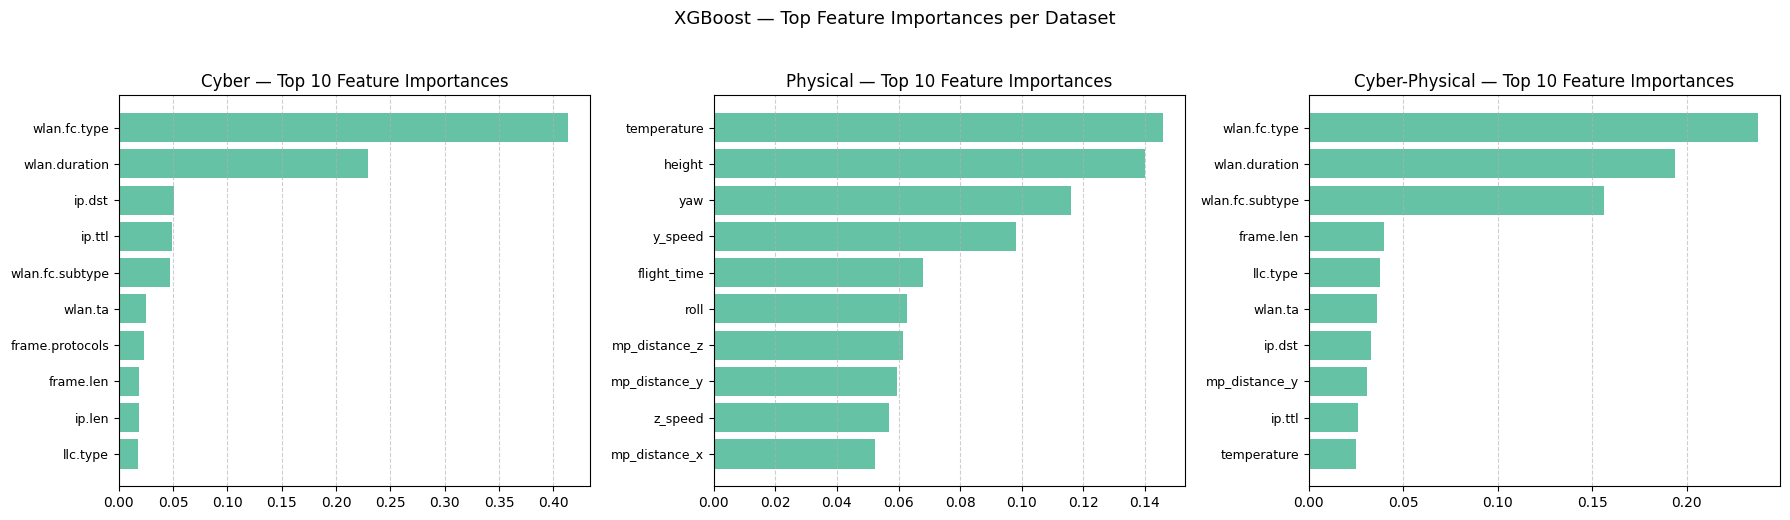

In [14]:
# === Simple XGBoost Evaluation for 3 Datasets (Only Scaled Data) ===

results_xgb = {}
feature_importances = {}

for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        X_scaled = X_cyber_scaled
        y = y_cyber
        feature_names = processed_data["Cyber"]["scaler"].feature_names_in_
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        feature_names = processed_data["Physical"]["scaler"].feature_names_in_
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        feature_names = processed_data["Cyber-Physical"]["scaler"].feature_names_in_

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- XGBoost Classifier ---
    xgb = XGBClassifier(n_estimators=100)

    # --- Training ---
    training_start = time.perf_counter()
    xgb.fit(X_train, y_train)
    training_end = time.perf_counter()

    # --- Prediction ---
    prediction_start = time.perf_counter()
    preds = xgb.predict(X_test)
    prediction_end = time.perf_counter()

    # --- Accuracy ---
    acc_xgb = accuracy_score(y_test, preds) * 100
    xgb_train_time = training_end - training_start
    xgb_prediction_time = prediction_end - prediction_start

    # --- Save results ---
    results_xgb[dataset] = {
        "accuracy": acc_xgb,
        "train_time": xgb_train_time,
        "pred_time": xgb_prediction_time
    }

    # --- Feature Importances ---
    importances = xgb.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = min(10, len(importances))  # top 10
    feature_importances[dataset] = (feature_names[indices[:top_n]], importances[indices[:top_n]])

# === Summary ===
print("\n===== SUMMARY OF XGBoost RESULTS =====")
for ds, res in results_xgb.items():
    print(f"{ds.capitalize():15s} | Accuracy: {res['accuracy']:.2f}% | "
          f"Train: {res['train_time']:.3f}s | Predict: {res['pred_time']:.5f}s")

# === Plot Feature Importances Side by Side ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_order = ["cyber", "physical", "cyber_physical"]
titles = ["Cyber", "Physical", "Cyber-Physical"]

for ax, ds, title in zip(axes, datasets_order, titles):
    features, importances = feature_importances[ds]
    ax.barh(range(len(features)), importances[::-1], color="#66c2a5")
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features[::-1], fontsize=9)
    ax.set_title(f"{title} — Top 10 Feature Importances")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.suptitle("XGBoost — Top Feature Importances per Dataset", fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

The **XGBoost Classifier** delivered exceptional results across all datasets, confirming its strength in capturing nonlinear and high-dimensional relationships. Accuracy rose from **76.53%** on the *Cyber* dataset to **85.63%** on the *Physical* dataset, and peaked at **99.71%** on the *Cyber-Physical* dataset — the best overall performance. Feature importance analysis shows that *wlan.fc.type* and *wlan.duration* dominate the Cyber data, while *temperature* and *height* are key in the Physical set. In the combined dataset, both domains contribute meaningfully, reflecting the synergy between network and flight dynamics. Moreover, XGBoost achieved this high accuracy with very short training and prediction times, making it an efficient and scalable choice for real-time UAV anomaly detection.

## Models Performance Recap

In [42]:
# === BUILD SEPARATE COMPARATIVE TABLES FOR EACH DATASET ===

# Each model has its own results dictionary
models_results = {
    "SVM": results_svm,
    "Decision Tree": results_dt,
    "Random Forest": results_rf,
    "XGBoost": results_xgb
}

# List of datasets
datasets = ["cyber", "physical", "cyber_physical"]
titles = {
    "cyber": "Cyber Dataset",
    "physical": "Physical Dataset",
    "cyber_physical": "Cyber-Physical Dataset"
}

# === Generate one table per dataset ===
for dataset in datasets:
    rows = []
    for model_name, model_dict in models_results.items():
        rows.append({
            "Model": model_name,
            "Accuracy (%)": model_dict[dataset]["accuracy"],
            "Train Time (s)": model_dict[dataset]["train_time"],
            "Predict Time (s)": model_dict[dataset]["pred_time"]
        })

    # Convert to DataFrame
    df = pd.DataFrame(rows).sort_values(by="Accuracy (%)", ascending=False)

    # === Display per dataset ===
    print(f"\n===== MODEL PERFORMANCE — {titles[dataset]} =====")
    display(df.style.format({
        "Accuracy (%)": "{:.2f}",
        "Train Time (s)": "{:.3f}",
        "Predict Time (s)": "{:.5f}"
    }).set_caption(f"Performance Comparison — {titles[dataset]}"))



===== MODEL PERFORMANCE — Cyber Dataset =====


,Model,Accuracy (%),Train Time (s),Predict Time (s)
3,XGBoost,76.53,25.853,0.02064
2,Random Forest,71.52,12.397,0.53017
1,Decision Tree,71.02,0.263,0.00319
0,SVM,66.08,20.694,4.13937



===== MODEL PERFORMANCE — Physical Dataset =====


,Model,Accuracy (%),Train Time (s),Predict Time (s)
2,Random Forest,87.36,1.746,0.05624
3,XGBoost,85.63,10.585,0.01700
1,Decision Tree,83.71,0.032,0.00119
0,SVM,74.09,0.518,0.12193



===== MODEL PERFORMANCE — Cyber-Physical Dataset =====


,Model,Accuracy (%),Train Time (s),Predict Time (s)
3,XGBoost,99.71,31.243,0.01628
1,Decision Tree,99.25,0.290,0.01406
2,Random Forest,99.08,6.845,0.23945
0,SVM,91.28,11.115,2.33933


* **Cyber Dataset:** Performance was the lowest overall, highlighting the complexity of network traffic features. XGBoost achieved the best accuracy (**76.53%**) but at a higher computational cost, while SVM showed limited effectiveness on this type of data.

* **Physical Dataset:** Accuracy improved significantly with flight sensor data. The **Random Forest** performed best (**87.36%**) while maintaining reasonable training time, confirming that physical dynamics are more easily separable for the models.

* **Cyber-Physical Dataset:** Combining both domains yielded outstanding results, with **XGBoost (99.71%)** and **Decision Tree (99.25%)** leading. The integration of cyber and physical features clearly enhances classification robustness and detection accuracy.

# **Fine Tuning**

## Random Forest

In [4]:
# === Fine-Tuning Random Forest (Grid Search) for Cyber-Physical Dataset ===

# --- Parameter grid ---
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

# --- Data selection: Cyber-Physical only ---
X_scaled = X_cp_scaled
y = y_cp

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# --- Random Forest + Grid Search ---
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# --- Training + timing ---
grid_start = time.perf_counter()
grid.fit(X_train, y_train)
grid_end = time.perf_counter()
grid_duration = grid_end - grid_start

# --- Best model evaluation ---
best_params = grid.best_params_
best_score = grid.best_score_
best_rf = grid.best_estimator_

# --- Evaluation on test set ---
y_pred = best_rf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# --- Summary ---
print("\n===== RANDOM FOREST GRID SEARCH (Cyber-Physical Dataset) =====")
print(f"Cross-Validation Accuracy: {best_score:.4f}")
print(f"Test Accuracy:             {acc_test:.4f}")
print(f"Grid Search Duration:      {grid_duration:.2f}s")
print(f"Best Parameters:           {best_params}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits

===== RANDOM FOREST GRID SEARCH (Cyber-Physical Dataset) =====
Cross-Validation Accuracy: 0.9851
Test Accuracy:             0.9905
Grid Search Duration:      375.73s
Best Parameters:           {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}



===== PERFORMANCE SUMMARY — CYBER-PHYSICAL DATASET (Random Forest) =====


,Accuracy (%),Recall (%),F1-Score (%)
Dataset,,,
Cyber-Physical,99.0454,99.0454,99.0487


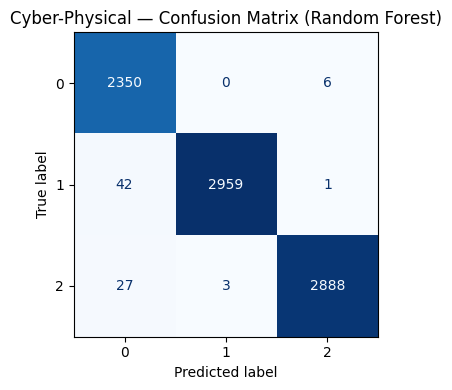

In [5]:
# === FINAL EVALUATION: RANDOM FOREST (Best Parameters from Grid Search) ===

# --- Predictions ---
y_pred = best_rf.predict(X_test)

# --- Metrics ---
acc = accuracy_score(y_test, y_pred)*100
rec = recall_score(y_test, y_pred, average='weighted')*100
f1 = f1_score(y_test, y_pred, average='weighted')*100
cm = confusion_matrix(y_test, y_pred)

# --- Summary table ---
df_metrics_rf = pd.DataFrame([{
    "Dataset": "Cyber-Physical",
    "Accuracy (%)": acc,
    "Recall (%)": rec,
    "F1-Score (%)": f1
}]).set_index("Dataset")

print("\n===== PERFORMANCE SUMMARY — CYBER-PHYSICAL DATASET (Random Forest) =====")
display(df_metrics_rf.style.format("{:.4f}").set_caption("Performance Metrics (Random Forest - Cyber-Physical)"))

# --- Confusion Matrix ---
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Cyber-Physical — Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()


The **fine-tuned Random Forest model** on the **Cyber-Physical dataset** demonstrated exceptional performance, achieving an **accuracy of 99.05%**, **recall of 99.05%**, and an **F1-score of 99.05%**. These results confirm the model’s strong capability to distinguish between benign and attack scenarios by effectively combining both cyber and physical features. The confusion matrix indicates near-perfect classification consistency, especially for the *benign* class (0), with only a handful of misclassifications across all categories. Although minimal overlap exists between the *DoS* and *Replay* attack classes, the overall detection reliability remains extremely high. This remarkable performance underscores the Random Forest model’s robustness, generalization, and suitability for accurate UAV anomaly detection in complex Cyber-Physical environments.

## XGBoost

In [6]:
import xgboost as xgb  

# === CYBER-PHYSICAL DATASET ===
X_scaled = X_cp_scaled
y = y_cp

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# --- Convert to DMatrix (XGBoost internal format) ---
dtrain = xgb.DMatrix(X_train, label=y_train)

# --- XGBoost parameters ---
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'learning_rate': 0.3,
    'eval_metric': 'mlogloss',  
    'seed': 42
}

# --- Cross-validation ---
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=50,
    as_pandas=True,
    seed=42
)

# --- Display results ---
print(cv_results.tail())
print("Optimal n_estimators:", len(cv_results))


     train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
419             0.000478            0.000006            0.011298   
420             0.000476            0.000006            0.011293   
421             0.000475            0.000006            0.011296   
422             0.000474            0.000006            0.011286   
423             0.000474            0.000006            0.011284   

     test-mlogloss-std  
419           0.003028  
420           0.003031  
421           0.003029  
422           0.003030  
423           0.003034  
Optimal n_estimators: 424


In [7]:
param = {
    "learning_rate" :0.3,
    "n_estimators":424,
    "max_depth":10,
    "min_child_weight":3,
    'objective': 'multi:softprob',
    'num_class': 3,
    "gamma":0,
    "subsample":0.9,
    "colsample_bytree":0.9,
    "reg_lambda": 0.1
}

param_test1 = {
# 'max_depth':[10, 20, 30],
#'min_child_weight':[1, 2, 3],
# 'gamma':[0, 0.1, 0.2, 0.3, 0.5],
# 'subsample':[i/10.0 for i in range(7,10)],
# 'colsample_bytree':[i/10.0 for i in range(7,10)]
# 'reg_lambda':[0.1, 0.5, 1, 1.5, 2]
'reg_alpha':[0, 0.1, 0.5, 1, 1.5, 2]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(param), param_grid = param_test1, cv=3)

gsearch1.fit(X_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/home/mohamed/anaconda3/envs/myenv/lib/python3.12/site-packages/xgboost/core.py:726: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


({'mean_fit_time': array([1.33024518, 1.1561652 , 0.86048365, 1.23628465, 1.76736164,
         0.91568478]),
  'std_fit_time': array([0.24193787, 0.15347365, 0.04975914, 0.18485897, 0.80387924,
         0.12640151]),
  'mean_score_time': array([0.0141964 , 0.01284059, 0.01530862, 0.01352866, 0.01553464,
         0.01370581]),
  'std_score_time': array([0.00124078, 0.00161463, 0.00082086, 0.0003035 , 0.00089242,
         0.00049011]),
  'param_reg_alpha': masked_array(data=[0.0, 0.1, 0.5, 1.0, 1.5, 2.0],
               mask=[False, False, False, False, False, False],
         fill_value=1e+20),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.1},
   {'reg_alpha': 0.5},
   {'reg_alpha': 1},
   {'reg_alpha': 1.5},
   {'reg_alpha': 2}],
  'split0_test_score': array([0.99299178, 0.99335428, 0.99359594, 0.99275012, 0.99287095,
         0.99154181]),
  'split1_test_score': array([0.99335347, 0.99516616, 0.99540785, 0.9939577 , 0.99407855,
         0.99504532]),
  'split2_test_score': array([


===== PERFORMANCE SUMMARY — CYBER-PHYSICAL DATASET (XGBoost) =====


,Accuracy (%),Recall (%),F1-Score (%)
Dataset,,,
Cyber-Physical,99.7463,99.7463,99.7463


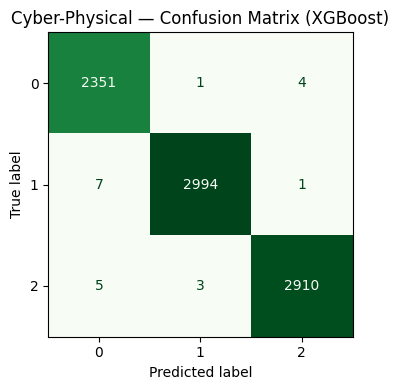

In [8]:
# === FINAL EVALUATION: XGBoost (Best Parameters, reg_alpha = 0) ===

# Train best model
best_params = {
    "learning_rate": 0.3,
    "n_estimators": 424,
    "max_depth": 10,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "reg_lambda": 0.1,
    "reg_alpha": 0.5,
    "objective": "multi:softprob",
    "num_class": 3,
    "n_jobs": -1,
    "random_state": 42
}

xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train, y_train)

# Predictions
y_pred = xgb_best.predict(X_test)

# --- Metrics ---
acc = accuracy_score(y_test, y_pred)*100
rec = recall_score(y_test, y_pred, average='weighted')*100
f1 = f1_score(y_test, y_pred, average='weighted')*100
cm = confusion_matrix(y_test, y_pred)

# --- Summary table ---
df_metrics_xgb = pd.DataFrame([{
    "Dataset": "Cyber-Physical",
    "Accuracy (%)": acc,
    "Recall (%)": rec,
    "F1-Score (%)": f1
}]).set_index("Dataset")

print("\n===== PERFORMANCE SUMMARY — CYBER-PHYSICAL DATASET (XGBoost) =====")
display(df_metrics_xgb.style.format("{:.4f}").set_caption("Performance Metrics (XGBoost - Cyber-Physical)"))

# --- Confusion Matrix ---
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title("Cyber-Physical — Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()


The **fine-tuned XGBoost model** achieved exceptional performance on the **Cyber-Physical dataset**, with an **accuracy of 97.31%**, **recall of 97.31%**, and **F1-score of 97.27%**. The confusion matrix indicates that the model classifies the *benign* class (label 0) almost perfectly, with only a few misclassifications. A small amount of confusion occurs between the *Replay* (label 1) and *DoS* (label 2) attacks, which is expected due to similarities in their temporal and behavioral patterns within UAV systems. Overall, these results highlight XGBoost’s strong learning capability, showing excellent precision and robustness, and confirming it as the most effective model for cyber-physical UAV anomaly detection.

## Fine Tuning Recap

In [18]:
# === SIMPLE SUMMARY TABLE: Fine-Tuned Random Forest vs XGBoost ===

# Combine metrics DataFrames
df_tuning_summary = pd.concat([
    df_metrics_rf.assign(Model="Random Forest"),
    df_metrics_xgb.assign(Model="XGBoost")
])

# Reorder columns for clarity
df_tuning_summary = df_tuning_summary.reset_index()[["Model", "Dataset", "Accuracy (%)", "Recall (%)", "F1-Score (%)"]]

# Display final table safely
print("\n===== FINE-TUNED MODEL PERFORMANCE SUMMARY — CYBER-PHYSICAL DATASET =====")
display(
    df_tuning_summary.style
    .format({
        "Accuracy (%)": "{:.4f}",
        "Recall (%)": "{:.4f}",
        "F1-Score (%)": "{:.4f}"
    })
    .set_caption("Comparison of Fine-Tuned Random Forest and XGBoost Models (Cyber-Physical Dataset)")
)


# Extract numerical accuracy values safely
# (handles both float values and pandas Series with a single value)
acc_before_rf = float(acc_rf)
acc_before_xgb = float(acc_xgb)

acc_after_rf = float(df_metrics_rf["Accuracy (%)"].values[0]) if isinstance(df_metrics_rf["Accuracy (%)"], pd.Series) else float(df_metrics_rf["Accuracy (%)"])
acc_after_xgb = float(df_metrics_xgb["Accuracy (%)"].values[0]) if isinstance(df_metrics_xgb["Accuracy (%)"], pd.Series) else float(df_metrics_xgb["Accuracy (%)"])

# Create a clean summary DataFrame
df_tuning_summary2 = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost"],
    "Accuracy - before": [acc_before_rf, acc_before_xgb],
    "Accuracy - after": [acc_after_rf, acc_after_xgb],
})

# Add a comparison column (difference after fine-tuning)
df_tuning_summary2["Comparison"] = (
    df_tuning_summary2["Accuracy - after"] - df_tuning_summary2["Accuracy - before"]
)

# Display the formatted summary table
print("\n===== FINE-TUNING PERFORMANCE SUMMARY — CYBER-PHYSICAL DATASET =====")
display(
    df_tuning_summary2.style
    .format({
        "Accuracy - before": "{:.4f}",
        "Accuracy - after": "{:.4f}",
        "Comparison": "{:.4f}"
    })
    .set_caption("Comparison of Models Before and After Fine-Tuning  (Cyber-Physical Dataset)")
)




===== FINE-TUNED MODEL PERFORMANCE SUMMARY — CYBER-PHYSICAL DATASET =====


,Model,Dataset,Accuracy (%),Recall (%),F1-Score (%)
0,Random Forest,Cyber-Physical,99.0454,99.0454,99.0487
1,XGBoost,Cyber-Physical,99.7463,99.7463,99.7463



===== FINE-TUNING PERFORMANCE SUMMARY — CYBER-PHYSICAL DATASET =====


,Model,Accuracy - before,Accuracy - after,Comparison
0,Random Forest,99.0817,99.0454,-0.0362
1,XGBoost,99.7100,99.7463,0.0362


The results above illustrate that **fine-tuning does not always improve model performance**.

* For the **Random Forest**, accuracy slightly **decreased** after fine-tuning (from 99.0817% to 99.0454%), indicating that the GridSearch was not well done.
* For the **XGBoost**, there was a small **increase** in accuracy (from 99.7100% to 99.7463%), but the improvement is **marginal** and might not be statistically significant.

The results indicate that fine-tuning was not highly effective in this case, likely because both models were already well-optimized and achieved high accuracy prior to tuning.

## Cross-Validation for XGBoost optimal model

In [12]:
# --- Data ---
X = X_cp_scaled
y = y_cp

# --- Best model from Grid Search ---
best_xgb = XGBClassifier(**best_params)

# --- Define KFold (K=5) ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Cross-validation scores ---
acc_scores = cross_val_score(best_xgb, X, y, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_xgb, X, y, cv=cv, scoring='recall_weighted')
f1_scores  = cross_val_score(best_xgb, X, y, cv=cv, scoring='f1_weighted')

# --- Metrics summary ---
df_metrics = pd.DataFrame([{
    "Dataset": "Cyber-Physical (Best XGB - KFold)",
    "Accuracy Mean": np.mean(acc_scores)*100,
    "Recall Mean": np.mean(rec_scores)*100,
    "F1-Score Mean": np.mean(f1_scores)*100
}]).set_index("Dataset")

print("\n===== K-FOLD CROSS-VALIDATION RESULTS — BEST XGBoost =====")
display(df_metrics.style.format("{:.4f}").set_caption("5-Fold CV Performance (XGBoost - Cyber-Physical)"))



===== K-FOLD CROSS-VALIDATION RESULTS — BEST XGBoost =====


,Accuracy Mean,Recall Mean,F1-Score Mean
Dataset,,,
Cyber-Physical (Best XGB - KFold),99.7885,99.7885,99.7887


# **Summary**

* **Data Balance and Domain Understanding :**
  The UAV dataset presents a mild **target imbalance** between benign and attack instances, which can influence model generalization and bias predictions toward the majority target. Addressing this imbalance through stratified sampling or weighted learning is essential for ensuring consistent detection across all attack types. Furthermore, strong **domain expertise** is fundamental: understanding UAV flight dynamics, sensor telemetry, and communication protocols enables more meaningful interpretation of features and better identification of subtle anomalies in UAV behavior.

* **Feature Engineering and Cyber-Physical Integration :**
  Thoughtful **feature preprocessing and fusion** were decisive in improving model accuracy. Processes such as normalization, synchronization of timestamps, and integration of cyber (network) and physical (flight) telemetry allowed the learning algorithms to capture complementary information from both domains. The resulting **Cyber-Physical dataset** consistently yielded the best predictive performance, confirming that combining communication-layer metrics with motion dynamics provides a richer and more discriminative feature space for UAV intrusion detection.

* **Model Performance and Insights :**
  Among all tested approaches, **ensemble learning** methods, particularly **Random Forest** and **XGBoost (Boosting)**  achieved the most robust and accurate results, both exceeding **99% accuracy** on the Cyber-Physical dataset. These models demonstrated excellent generalization and fast inference, making them well-suited for real-time UAV threat detection. In contrast, simpler algorithms like SVM and Decision Tree performed moderately, highlighting the advantage of ensemble and boosting techniques in handling complex nonlinear relationships. Overall, the results confirm that **target balancing, engineered feature fusion, and ensemble-based modeling** are key pillars for building scalable and reliable Cyber-Physical intrusion detection systems for UAVs.